2025-06-12 22:43:16,312 - INFO - Début du pipeline de clustering MiniBatch K-Means
2025-06-12 22:43:17,784 - INFO - 267468 vecteurs ACP chargés
2025-06-12 22:43:17,793 - INFO - Échantillon pour évaluation silhouette : 53494 lignes
2025-06-12 22:43:47,332 - INFO -    k=2 | silhouette = 0.3770
2025-06-12 22:44:15,816 - INFO -    k=3 | silhouette = 0.3750
2025-06-12 22:44:43,209 - INFO -    k=4 | silhouette = 0.3443
2025-06-12 22:45:11,363 - INFO -    k=5 | silhouette = 0.3112
2025-06-12 22:45:38,771 - INFO -    k=6 | silhouette = 0.2672
2025-06-12 22:46:06,575 - INFO -    k=7 | silhouette = 0.2920
2025-06-12 22:46:33,483 - INFO -    k=8 | silhouette = 0.2818
2025-06-12 22:47:01,040 - INFO -    k=9 | silhouette = 0.2538
2025-06-12 22:47:28,270 - INFO -    k=10 | silhouette = 0.2513
2025-06-12 22:47:28,271 - INFO - Meilleur k trouvé : 2
2025-06-12 22:47:30,782 - INFO - Données clusterisées exportées dans 'acp_clusters'


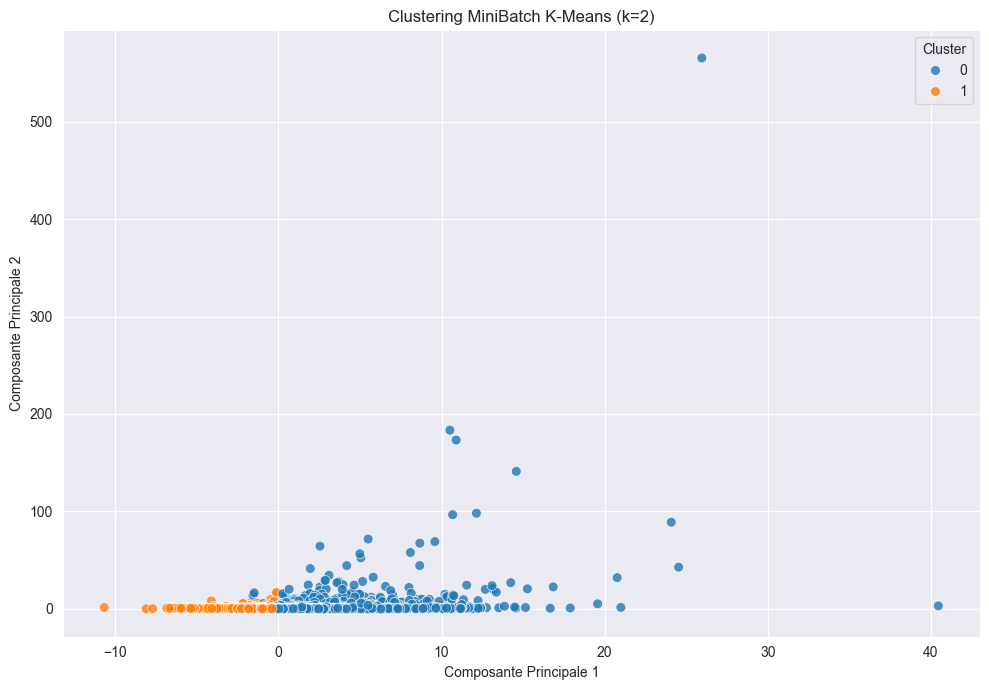

2025-06-12 22:47:47,363 - INFO - Visualisation sauvegardée : clusters_acp_pc1_pc2.png
2025-06-12 22:47:47,364 - INFO - Début de la détection des profils atypiques
2025-06-12 22:57:43,863 - INFO - 2678 profils atypiques détectés (au-dessus du 99e percentile)
2025-06-12 22:57:43,897 - INFO - Profils atypiques sauvegardés dans 'acp_outliers'


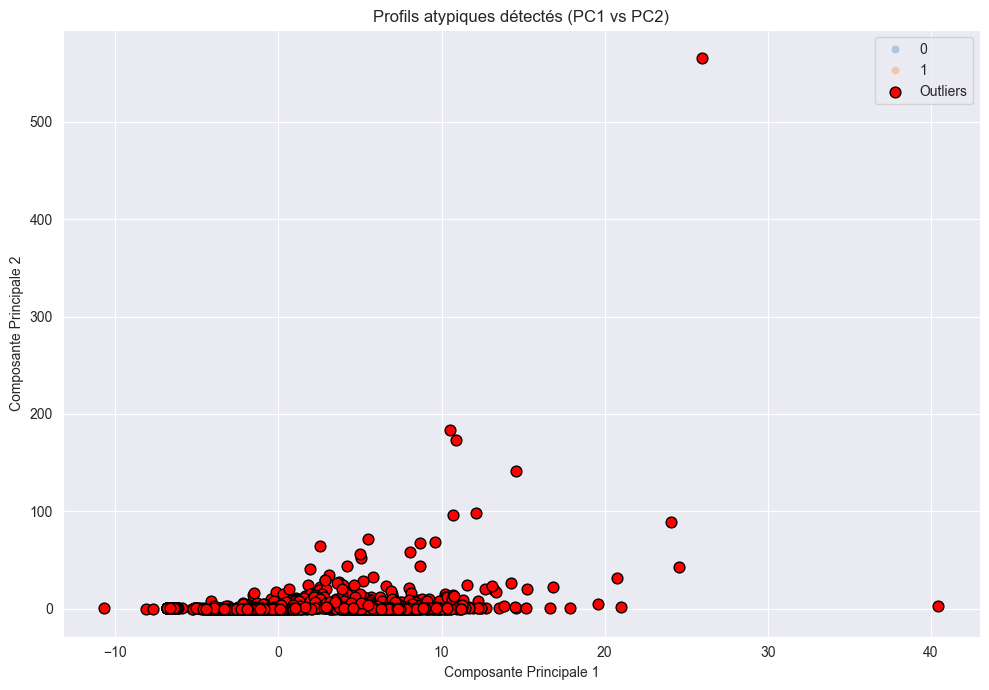

2025-06-12 22:58:02,026 - INFO - Visualisation des outliers sauvegardée : outliers_acp_pc1_pc2.png
2025-06-12 22:58:02,027 - INFO - Connexion MongoDB fermée
2025-06-12 22:58:02,028 - INFO - Pipeline MiniBatch K-Means terminé avec succès
2025-06-12 22:58:02,028 - INFO - Pipeline MiniBatch K-Means terminé avec succès


In [3]:
import os
import logging
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Environnement
def setup_environment():
    for folder in ["logs", "images"]:
        os.makedirs(folder, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"logs/clustering_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log", encoding="utf-8"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_environment()
logger.info("Début du pipeline de clustering MiniBatch K-Means")

try:
    # 2. Connexion MongoDB & Chargement des données ACP
    client = MongoClient("localhost", 27017)
    db = client["IF29_twitter_db"]
    collection = db["acp_db"]
    
    # Charger uniquement les composantes principales
    fields = {"_id": 1, "PC1": 1, "PC2": 1, "PC3": 1, "PC4": 1, "PC5": 1}
    data = pd.DataFrame(list(collection.find({}, fields)))
    
    if data.empty:
        raise ValueError("Aucune donnée trouvée dans 'acp_db'")

    id_list = data.pop("_id")
    logger.info(f"{len(data)} vecteurs ACP chargés")

    # 3. Sous-échantillonnage pour recherche de k optimal
    sample_frac = 0.2 if len(data) > 10000 else 1.0
    data_sample = data.sample(frac=sample_frac, random_state=42)
    logger.info(f"Échantillon pour évaluation silhouette : {len(data_sample)} lignes")

    # 4. Détermination du meilleur k (score silhouette)
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        model = MiniBatchKMeans(
            n_clusters=k,
            random_state=42,
            batch_size=2048,
            n_init="auto",
            max_no_improvement=20
        )
        labels = model.fit_predict(data_sample)
        score = silhouette_score(data_sample, labels)
        silhouette_scores.append(score)
        logger.info(f"   k={k} | silhouette = {score:.4f}")

    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    logger.info(f"Meilleur k trouvé : {best_k}")

    # 5. Clustering complet sur tous les points
    final_model = MiniBatchKMeans(
        n_clusters=best_k,
        random_state=42,
        batch_size=2048,
        n_init="auto",
        max_no_improvement=20
    )
    data["cluster"] = final_model.fit_predict(data)
    data.insert(0, "_id", id_list)

    # 6. Export MongoDB
    db.drop_collection("acp_clusters")
    db["acp_clusters"].insert_many(data.to_dict("records"))
    logger.info("Données clusterisées exportées dans 'acp_clusters'")

    # 7. Visualisation (PC1 vs PC2)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=data, x="PC1", y="PC2", hue="cluster", palette="tab10", s=50, alpha=0.8)
    plt.title(f"Clustering MiniBatch K-Means (k={best_k})")
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig("images/clusters_acp_pc1_pc2.png")
    plt.show()
    plt.close()
    logger.info("Visualisation sauvegardée : clusters_acp_pc1_pc2.png")
    ####
    # 8. Détection des profils atypiques (outliers)
    from sklearn.metrics import pairwise_distances_argmin_min

    logger.info("Début de la détection des profils atypiques")

    # Récupérer les centroïdes du modèle final
    centroids = final_model.cluster_centers_

    # Calcul des distances à leur centroïde
    closest, distances = pairwise_distances_argmin_min(data[["PC1", "PC2", "PC3", "PC4", "PC5"]], centroids[data["cluster"]])
    data["distance_to_centroid"] = distances

    # Seuil pour les outliers (ex: top 1% des plus éloignés)
    seuil_quantile = 0.99
    seuil = data["distance_to_centroid"].quantile(seuil_quantile)
    outliers = data[data["distance_to_centroid"] >= seuil]
    logger.info(f"{len(outliers)} profils atypiques détectés (au-dessus du {seuil_quantile*100:.0f}e percentile)")

    # Sauvegarde MongoDB
    db.drop_collection("acp_outliers")
    db["acp_outliers"].insert_many(outliers.to_dict("records"))
    logger.info("Profils atypiques sauvegardés dans 'acp_outliers'")

    # Visualisation des outliers sur PC1-PC2
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=data, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.3)
    plt.scatter(outliers["PC1"], outliers["PC2"], color="red", label="Outliers", s=60, edgecolor="black")
    plt.title("Profils atypiques détectés (PC1 vs PC2)")
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/outliers_acp_pc1_pc2.png")
    plt.show()
    plt.close()
    logger.info("Visualisation des outliers sauvegardée : outliers_acp_pc1_pc2.png")

except Exception as e:
    logger.error(f"Erreur dans le pipeline : {str(e)}")
    raise

finally:
    if "client" in locals():
        client.close()
        logger.info("Connexion MongoDB fermée")

logger.info("Pipeline MiniBatch K-Means terminé avec succès")
logger.info("Pipeline MiniBatch K-Means terminé avec succès")



Comparaison statistique :

                         Moyenne globale  Moyenne outliers         Écart
followers_count             7.829830e+03      4.494981e+05  4.416683e+05
friends_count               1.101990e+03      9.227010e+03  8.125020e+03
favourites_count            9.108700e+03      3.512569e+04  2.601699e+04
statuses_count              2.220438e+04      2.197489e+05  1.975445e+05
tweets_per_day              4.770000e+00      4.553000e+01  4.077000e+01
followers_friends_ratio     1.699500e+02      1.424829e+04  1.407834e+04
engagement_ratio            1.130000e+00      6.163000e+01  6.049000e+01
popularity_score            6.973299e+08      6.898086e+10  6.828353e+10
avg_num_hashtags            1.560000e+00      1.780000e+00  2.300000e-01
avg_num_mentions            9.100000e-01      8.300000e-01 -7.000000e-02
avg_num_urls                2.700000e-01      4.000000e-01  1.300000e-01
avg_retweet_count           0.000000e+00      0.000000e+00  0.000000e+00
avg_reply_count        

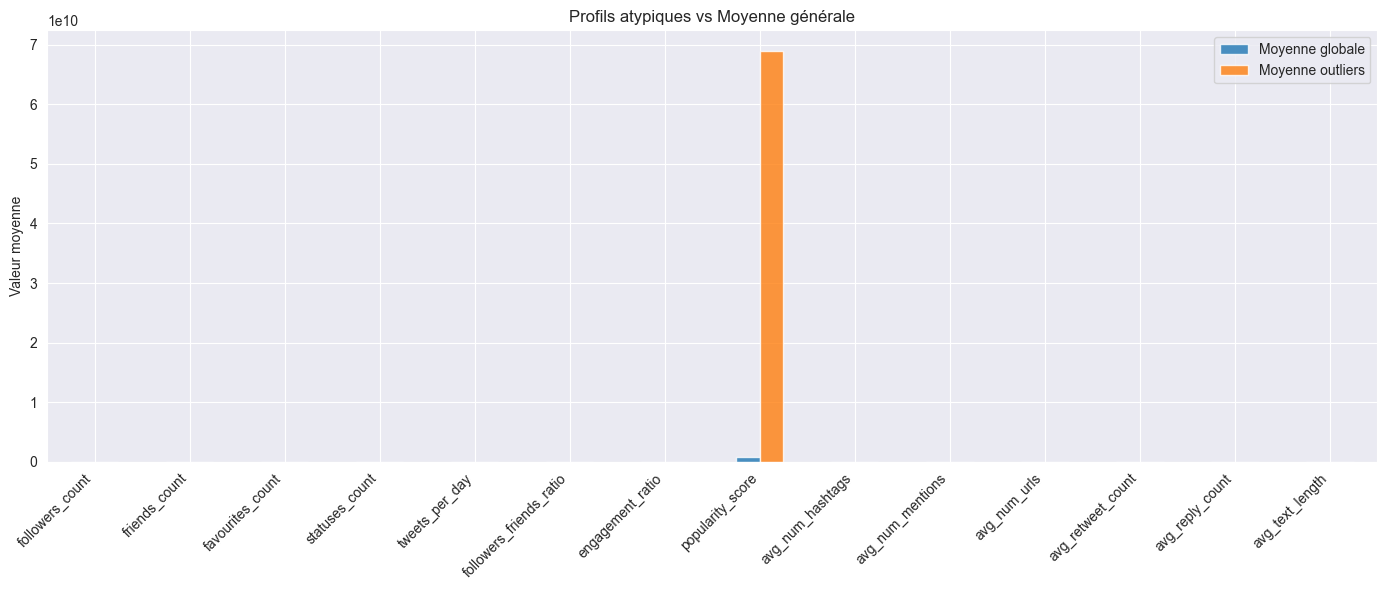

In [8]:
# Étape 1 – Connexion Mongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt

client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Étape 2 – Charger les données utiles
outliers_df = pd.DataFrame(list(db["acp_outliers"].find({}, {"_id": 1})))
acp_db_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))
users_df = pd.DataFrame(list(db["user_db"].find()))

# Étape 3 – Associer les outliers avec leurs user_id via acp_db
merged_df = pd.merge(outliers_df, acp_db_df, on="_id", how="left")

# Étape 4 – Fusion finale avec user_db
outliers_users_df = pd.merge(merged_df, users_df, left_on="user_id", right_on="_id", how="left")

# Étape 5 – Nettoyage
outliers_users_df.drop(columns=["_id_x", "_id_y"], inplace=True)

# Étape 6 – Charger tous les users (pour comparaison globale)
acp_all_df = pd.merge(acp_db_df, users_df, left_on="user_id", right_on="_id", how="left")

# Étape 7 – Analyse statistique
variables = [
    "followers_count", "friends_count", "favourites_count", "statuses_count",
    "tweets_per_day", "followers_friends_ratio", "engagement_ratio", "popularity_score",
    "avg_num_hashtags", "avg_num_mentions", "avg_num_urls", "avg_retweet_count", "avg_reply_count",
    "avg_text_length"
]

comparison_df = pd.DataFrame({
    "Moyenne globale": acp_all_df[variables].mean(),
    "Moyenne outliers": outliers_users_df[variables].mean(),
})
comparison_df["Écart"] = comparison_df["Moyenne outliers"] - comparison_df["Moyenne globale"]

# Affichage
print("\nComparaison statistique :\n")
print(comparison_df.round(2))

# Visualisation
comparison_df[["Moyenne globale", "Moyenne outliers"]].plot(kind="bar", figsize=(14, 6), alpha=0.8)
plt.title("Profils atypiques vs Moyenne générale")
plt.ylabel("Valeur moyenne")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/comparaison_outliers_utilisateurs.png")
plt.show()


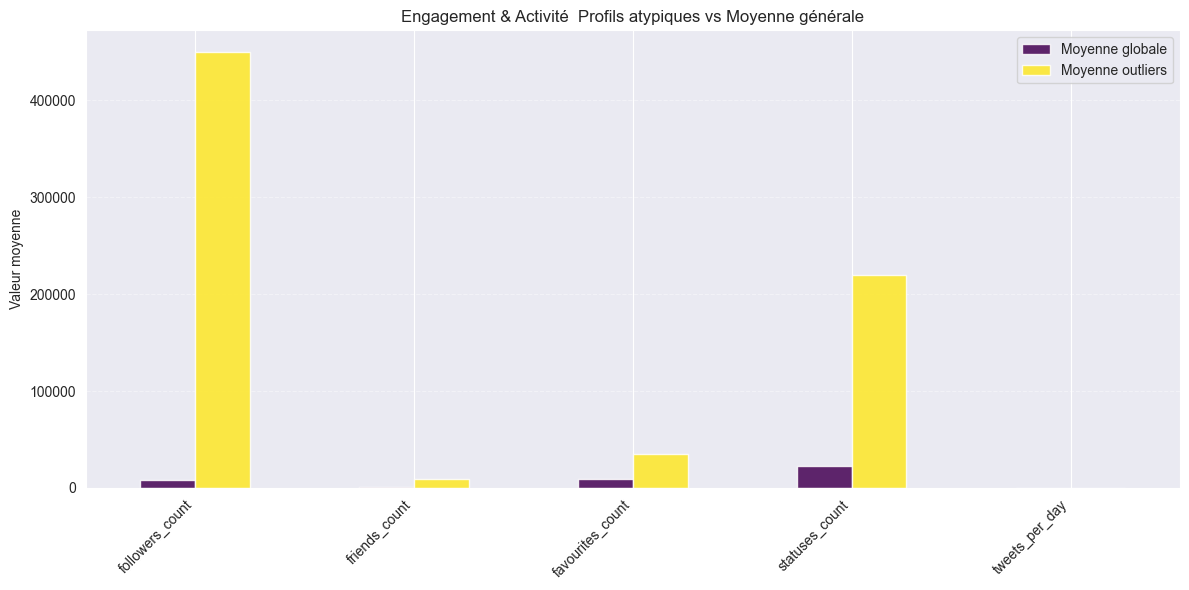

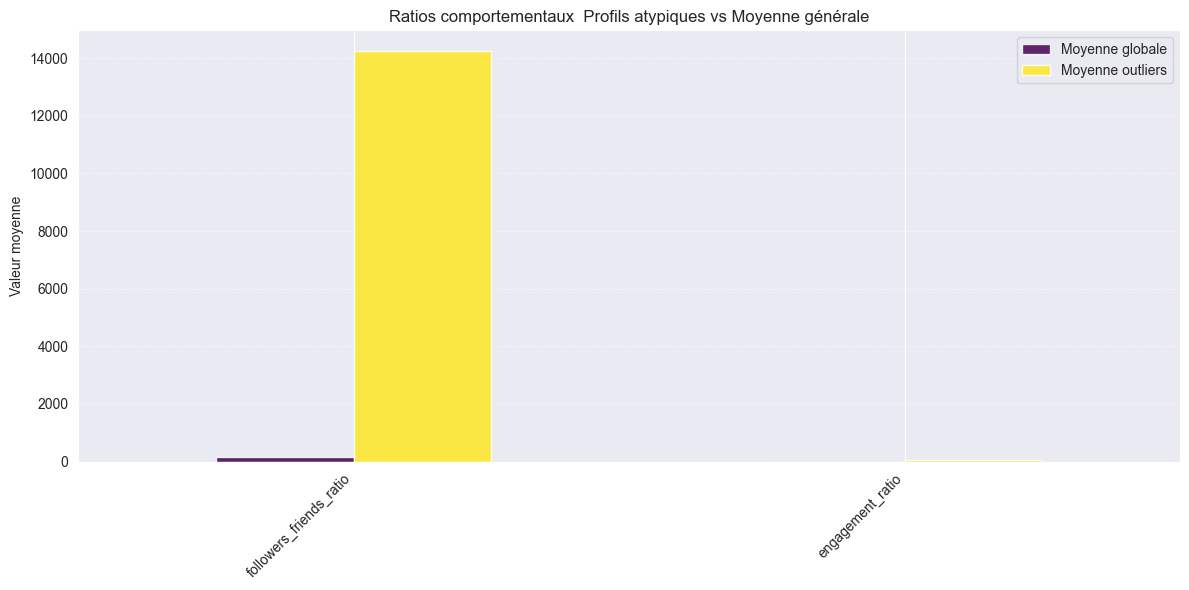

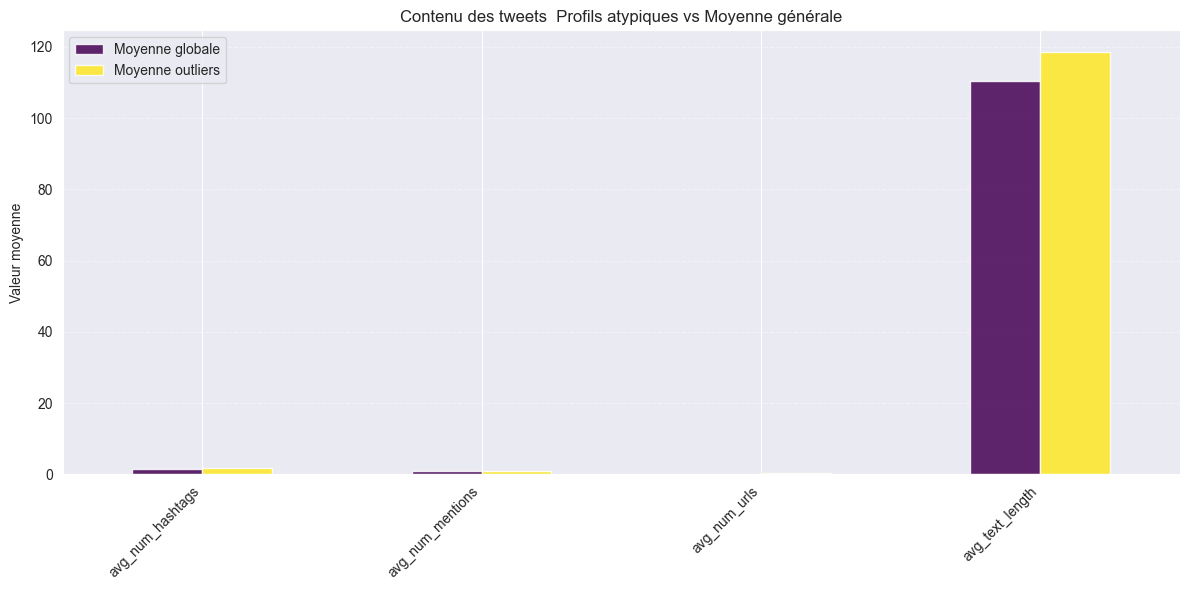

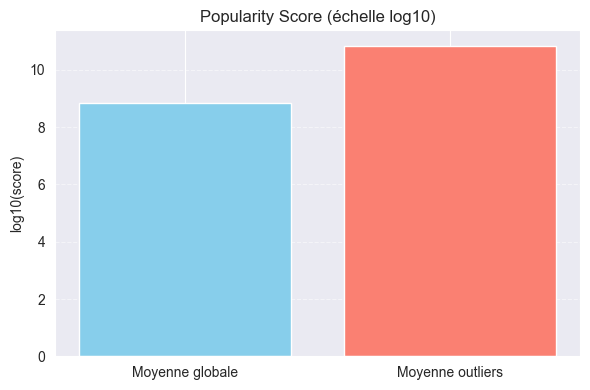

In [11]:
import numpy as np

# Définir les groupes thématiques
groupes = {
    "Engagement & Activité": [
        "followers_count", "friends_count", "favourites_count",
        "statuses_count", "tweets_per_day"
    ],
    "Ratios comportementaux": [
        "followers_friends_ratio", "engagement_ratio"
    ],
    "Contenu des tweets": [
        "avg_num_hashtags", "avg_num_mentions", "avg_num_urls", "avg_text_length"
    ]
}

# Afficher les barres par groupe
for nom_groupe, colonnes in groupes.items():
    sub_df = comparison_df.loc[colonnes]

    sub_df[["Moyenne globale", "Moyenne outliers"]].plot(
        kind="bar", figsize=(12, 6),
        title=f"{nom_groupe}  Profils atypiques vs Moyenne générale",
        colormap="viridis", alpha=0.85
    )
    plt.ylabel("Valeur moyenne")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"images/comparaison_outliers_{nom_groupe.replace(' ', '_').lower()}.png")
    plt.show()

# Popularity_score à part avec échelle log (optionnel mais recommandé)
plt.figure(figsize=(6, 4))
plt.bar(
    ["Moyenne globale", "Moyenne outliers"],
    [np.log10(comparison_df.loc["popularity_score", "Moyenne globale"]),
     np.log10(comparison_df.loc["popularity_score", "Moyenne outliers"])],
    color=["skyblue", "salmon"]
)
plt.title("Popularity Score (échelle log10)")
plt.ylabel("log10(score)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("images/popularity_score_log10.png")
plt.show()
